# Installing tools
First of all we install all the needed software in order to run the rest of the script.


In [ ]:
!apt-get install curl tshark tcpdump dnsutils >> /content/file.log
!pip install pyshark >> /content/file.log
!pip install --pre scapy[basic] >> /content/file.log

# Considerations for capturing traffic

In [ ]:
!dig +short www.cnn.com

cnn-tls.map.fastly.net.
151.101.3.5
151.101.67.5
151.101.131.5
151.101.195.5


<font size="5">Some dns request will return multiple IP addresses and this is due to the Global Server Load Balancing. </font>



In [ ]:
!tcpdump -i eth0 -w "prova.pcap"

tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
104 packets captured
109 packets received by filter
0 packets dropped by kernel


In [ ]:
!ifconfig

eth0: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 172.28.0.12  netmask 255.255.0.0  broadcast 172.28.255.255
        ether 02:42:ac:1c:00:0c  txqueuelen 0  (Ethernet)
        RX packets 3434  bytes 30240077 (30.2 MB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 2971  bytes 493265 (493.2 KB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0

lo: flags=73<UP,LOOPBACK,RUNNING>  mtu 65536
        inet 127.0.0.1  netmask 255.0.0.0
        loop  txqueuelen 1000  (Local Loopback)
        RX packets 7222  bytes 2904176 (2.9 MB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 7222  bytes 2904176 (2.9 MB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0



<font size="4.8">Listening to the eth0 interface we can see that there is a TCP connection inside the virtual machine. </font>

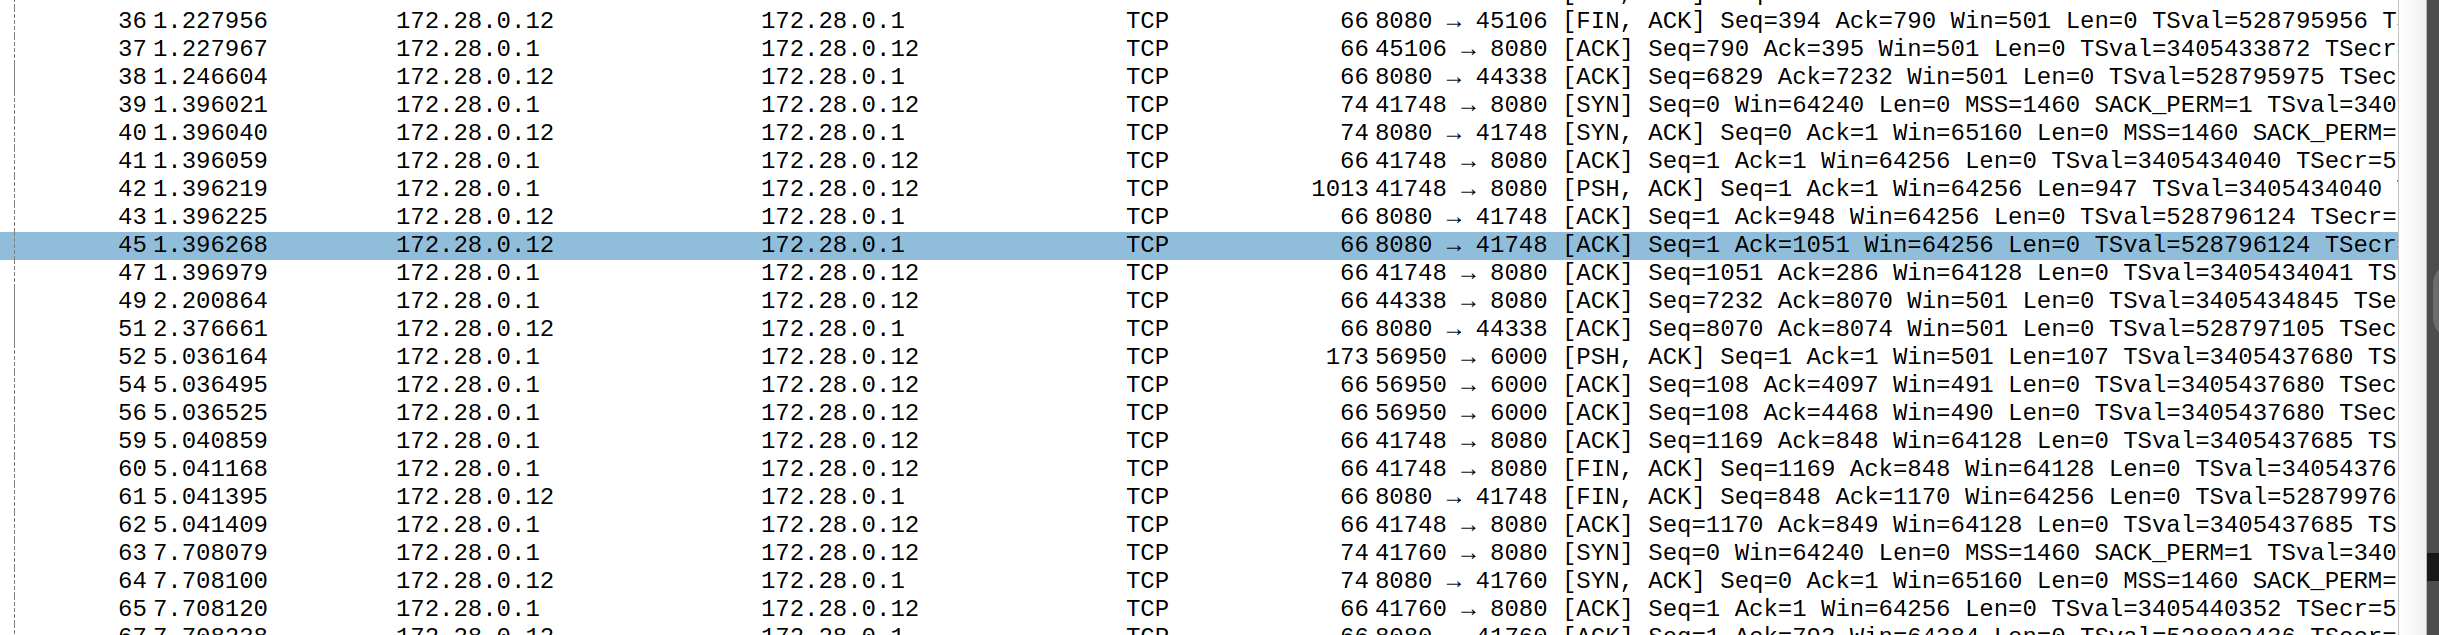

In [ ]:
!tcpdump -i eth0 -w "prova.pcap" & (sleep 3; curl https://www.news.google.com)

tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
<HTML><HEAD><meta http-equiv="content-type" content="text/html;charset=utf-8">
<TITLE>301 Moved</TITLE></HEAD><BODY>
<H1>301 Moved</H1>
The document has moved
<A HREF="https://news.google.com/">here</A>.
</BODY></HTML>
104 packets captured
117 packets received by filter
0 packets dropped by kernel


<font size="4.8">Using the curl we can see that tcpdump need a little bit of time to start: $$\simeq 0.20s$$  This can be seen since it should have captured the **DNS** query at 3.0s based on the terminal command. Instead it captured the **DNS** query after 2.8s.

We can see that there is another tcp connection between **172.28.0.1** and **172.28.0.12**, this is very likely some management traffic. Since this traffic happens on different ports with respect to the standard one, to get rid of the traffic we are not interesting we can just filter on the **port 443** </font>

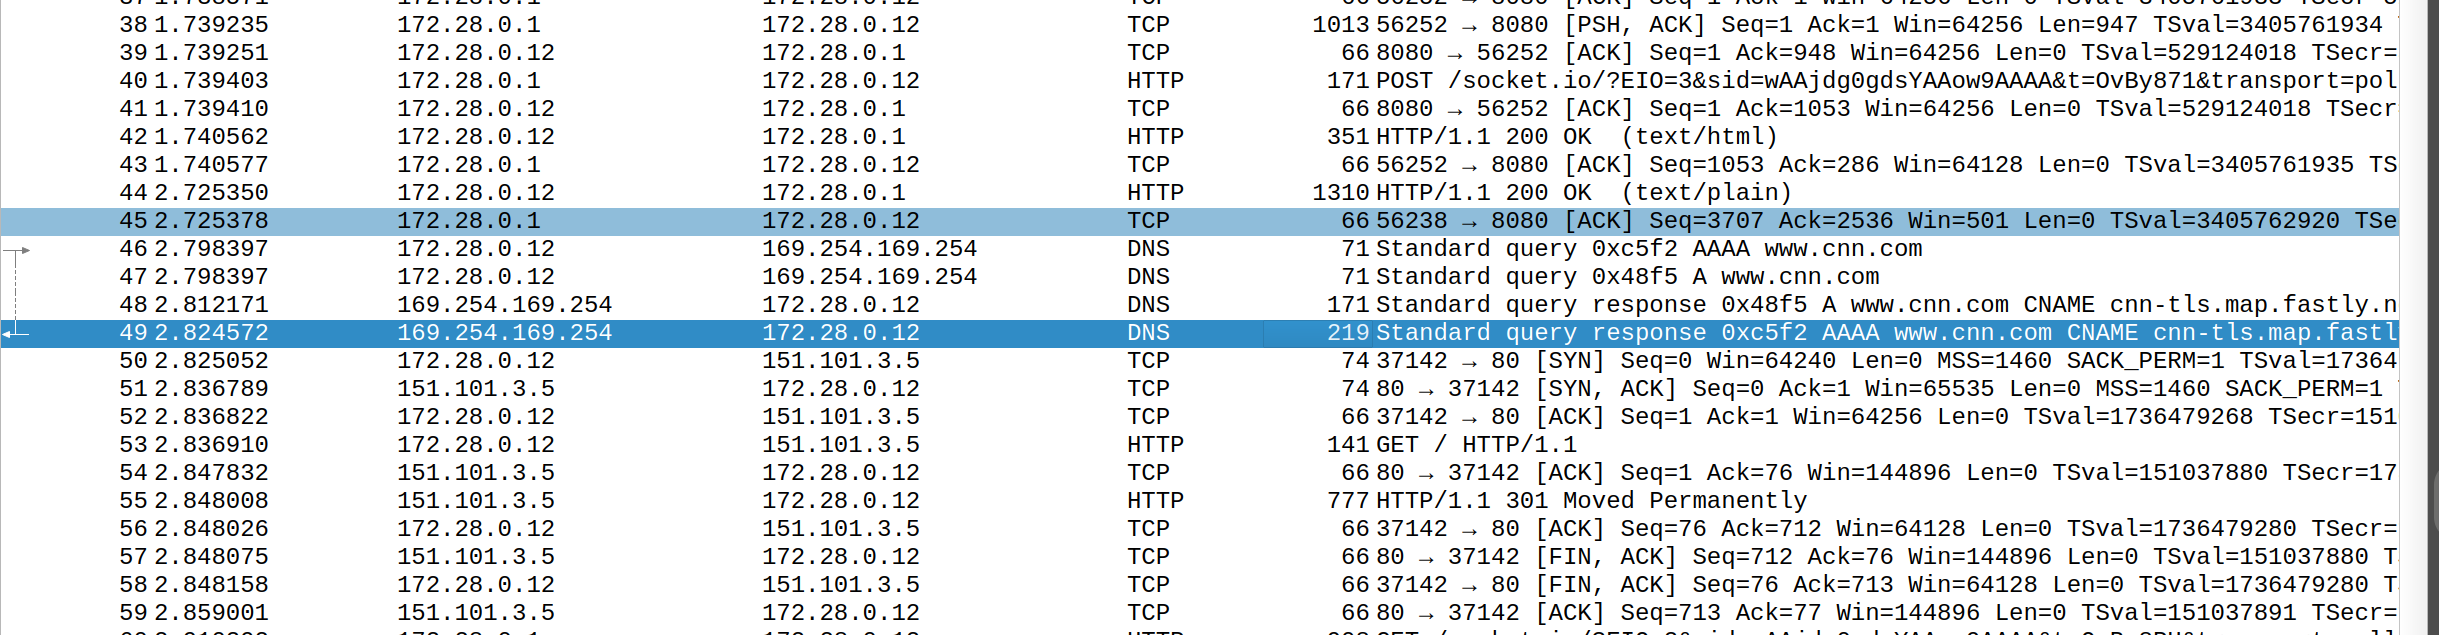

# Capturing Traffic
<font size="4.8">For capturing traffic in an automatic way the traffic a bash script is used. It is devided into two code blocks:

<font size="4.8">**Block 1**:

  <font size="4.8">-> It iterate on a **list of urls**

  <font size="4.8">-> For each url it will **repeat few times**

  <font size="4.8">-> In each loop it is going to **create a .pcap** file using **tcpdump** which will store the capture resulted by the curl.

  <font size="4.8">-> Then after the capture is completed the **tcpdump process is killed** through the kill command which uses the process id


<font size="4.8">**BLOCK 2**

<font size="4.8">Since the previous block created all the files in .pcap format they were all converted into .csv in the following way:

<font size="4.8">-> Retrieve the **current directory**

<font size="4.8">-> Looping for each file into the current directory with .**pcap extension**

<font size="4.8">-> we **create a new file** with the name switched in order to match the .csv file

<font size="4.8">-> then **tshark** was used for the conversion</font>

In [ ]:
%%shell

urls=(

  "https://www.bbc.co.uk"
  "https://www.msn.com"
  "https://www.cnn.com"
  "https://www.news.google.com"
  "https://www.dailymail.co.uk"
  "https://www.nytimes.com"
  "https://www.theguardian.com"
  "https://www.foxnews.com"
  "https://www.finance.yahoo.com"
  "https://www.news.yahoo.com"

)

#LOOPING THROUGH EACH URL
for i in "${urls[@]}"
do

  #EXTRACTING THE DOMAIN
  domain="${i#https://}"
  #INITIALIZING COUNTER FOR FILE NAME
  count=1

  #LOOPING 10 TIMES FOR EACH URL
  for ((j=1; j<=3; j++))
  do

    #CREATING THE FILE NAME
    filename="$domain$count.pcap"
    #IF THE FILE DOES NOT EXISTS
    if [ ! -e $filename ]
    then
      #CREATE A FILE
      touch $filename
    fi

    #TCPDUMP WILL LISTEN ON THE ETH0 INTERFACE FOR PACKETS HAVE THE PORT
    # EITHER SOURCE OR DESTINATION = 443
    tcpdump -i eth0 -nn -X "port 443" -w "$filename" & tcpdump_pid=$! >> file.log
    # THE SLEEP I SET TO 0.4s IN ORDER TO START THE CONNECTION AFTER TCPDUMP HAS
    # STARTED. IT SHOULD TAKE 0.2s BUT TO BE SURE OF NOT MISSING ANY PACKETS
    # THE SLEEP WAS SET TO 0.4
    (sleep 0.4; curl -s $i >> file.log)

    #THIS SLEEP TAKES IN TO ACCOUNT THE DURATION OF THE ENTIRE CONVERSATION
    # PLUS THE TIME NEEDED TO SAVE THE FILE.
    sleep 1.5

    #THE PROCESS IS KILLED SINCE IT WOULD NOT STOP AUTOMATICALLY
    kill "$tcpdump_pid"
    echo "[CAPTURE_FUNCTION] The capture n:$count as ended"
    echo "[CAPTURE_FUNCTION] It was for url: $i"
    count=$(($count+1))
  done
done



tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
[CAPTURE_FUNCTION] The capture n:1 as ended
[CAPTURE_FUNCTION] It was for url: https://www.bbc.co.uk
201 packets captured
201 packets received by filter
0 packets dropped by kernel
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
[CAPTURE_FUNCTION] The capture n:2 as ended
[CAPTURE_FUNCTION] It was for url: https://www.bbc.co.uk
187 packets captured
187 packets received by filter
0 packets dropped by kernel
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
[CAPTURE_FUNCTION] The capture n:3 as ended
[CAPTURE_FUNCTION] It was for url: https://www.bbc.co.uk
184 packets captured
184 packets received by filter
0 packets dropped by kernel
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
[CAPTURE_FUNCTION] The capture n:1 as ended
[CAPTURE_FUNCTION] It was for url: https://www.msn.com
66 packets cap

In [ ]:
%%shell
#!/bin/bash

cur_dir=$(pwd)

# Iterate over pcap files
for file in *.pcap
do
  echo "[NAME OF THE FILE]: $file"
  # Extract filename without extension
  filename_without_extension=$(basename "$file" .pcap)

  # Check if CSV file already exists, if not create it
  csv_file="${filename_without_extension}.csv"
  if [ ! -e "$csv_file" ]; then
    touch "$csv_file"
  fi

  # Convert pcap to csv using tshark
  tshark -r "$file" -T fields  -E header=y -E separator=, -E quote=d -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport -e frame.time -e frame.len -e tcp.len -e ip.len -e tcp.flags > "$csv_file"
done

[NAME OF THE FILE]: www.bbc.co.uk1.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.bbc.co.uk2.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.bbc.co.uk3.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.cnn.com1.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.cnn.com2.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.cnn.com3.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.dailymail.co.uk1.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.dailymail.co.uk2.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.dailymail.co.uk3.pcap
Running as user "root" and group "root". This could be dangerous.
[NAME OF THE FILE]: www.finance.ya

In [ ]:
!zip data_3_instance.zip *.pcap>/dev/null
!zip data_3_csv.zip *.csv > /dev/null

In [ ]:
#We save all the pcaps in a zip file and we also save all the csv
!zip data_10_instance.zip *.pcap >/dev/null
!zip data_10_csv.zip *.csv >/dev/null

## Analysing the .pcap file

The resulting traffic is starting with:
**Three way handshake**

-> TCP SYN

-> TCP SYN,ACK

-> TCP ACK

**TLS**
Then there is the TLS client hello and the communication is starting where all the application data will go on TLS protocol while the TCP will be used only for ACKS.

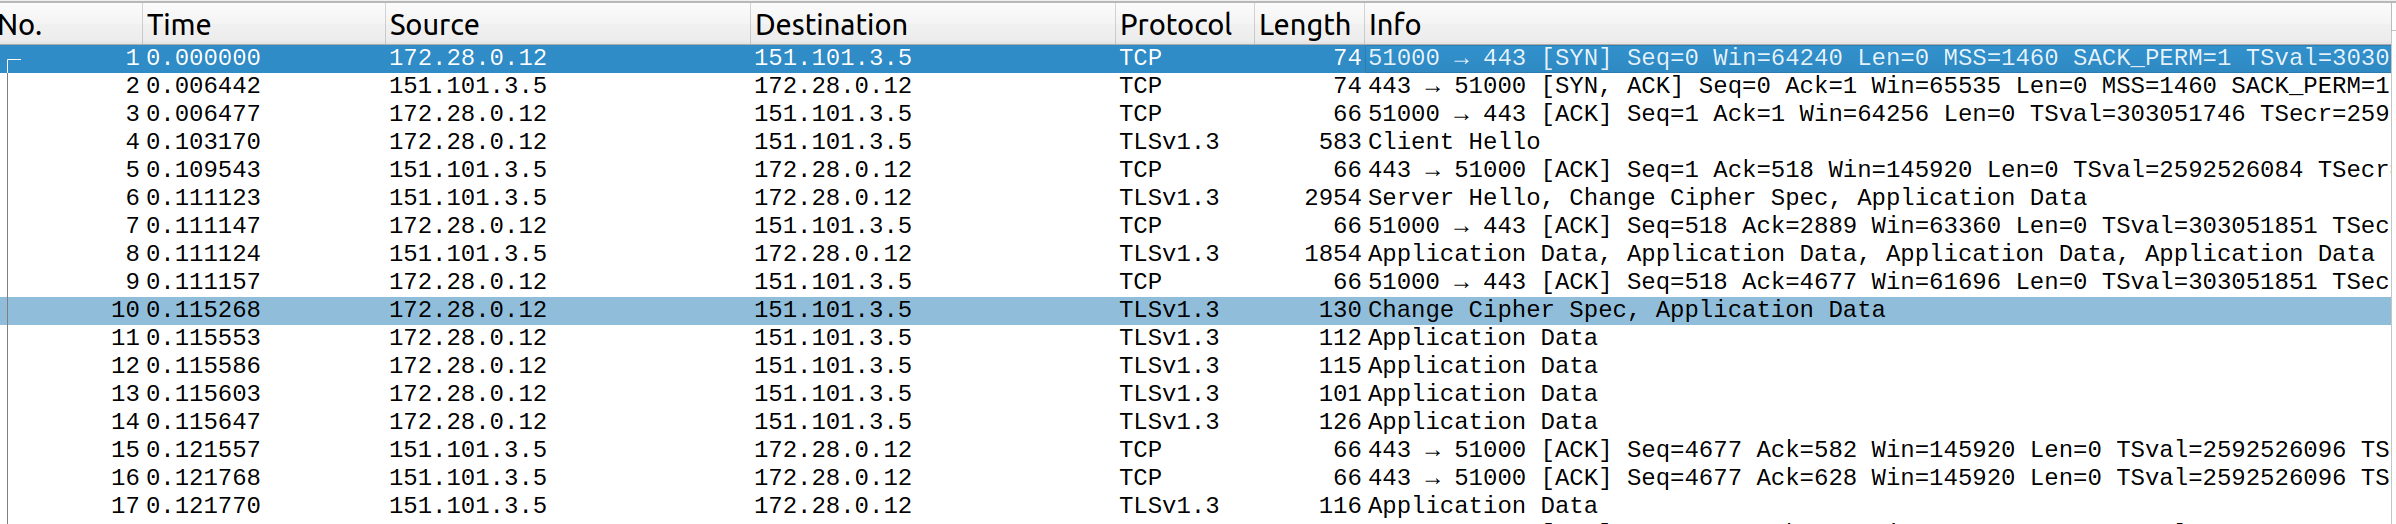

At the end there is the FIN,ACK mechanism to close the connection.

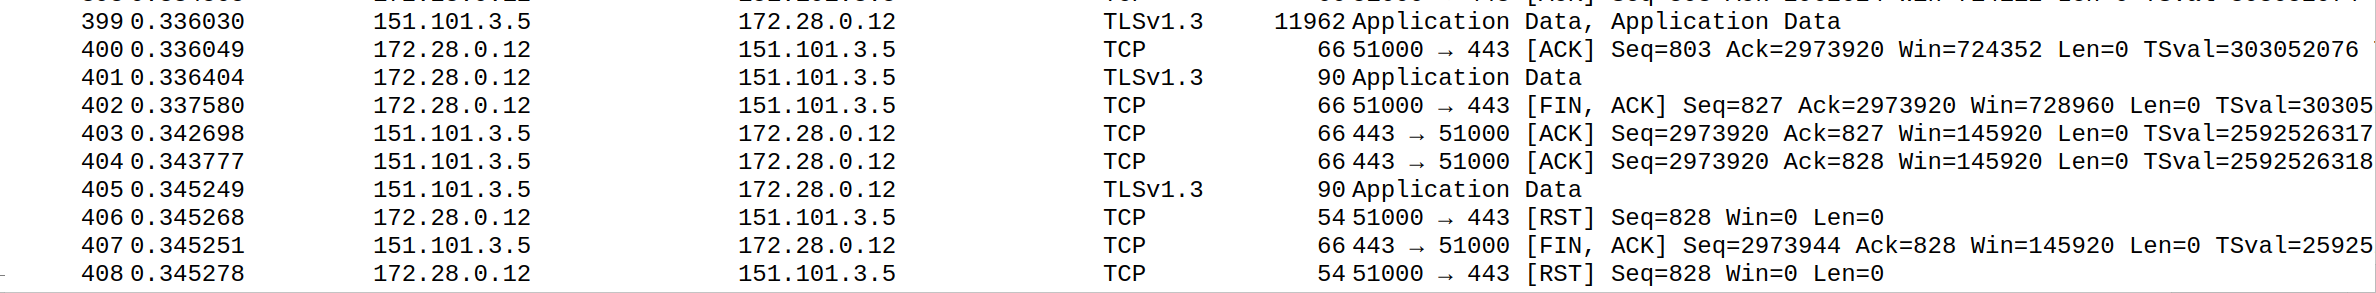

This can be exploited to understand the direction of the flow very easily with an .iloc

# Python part

In [ ]:
import os
import pandas as pd
import re

In [ ]:
def extract_parameters(parameters: dict, flow, df_flow):



  parameters[f"avg.packet.size.{flow}"] = [df_flow["ip.len"].astype(float).mean()]
  parameters[f"min.packet.size.{flow}"] = [df_flow["ip.len"].astype(float).min()]
  parameters[f"max.packet.size.{flow}"] = [df_flow["ip.len"].astype(float).max()]
  parameters[f"std.packet.size.{flow}"] = [df_flow["ip.len"].astype(float).std()]
  parameters[f"count.packets.{flow}"] = [len(df_flow["ip.len"])]
  parameters[f"total.packets.{flow}"] = [df_flow["ip.len"].astype(float).sum()]

  times = pd.to_datetime(df_flow["frame.time"], format='%b %d, %Y %H:%M:%S.%f000 UTC').diff(1).dt.total_seconds().iloc[1:]

  parameters[f"max.iat.{flow}"] = [times.max()]
  parameters[f"min.iat.{flow}"] = [times.min()]
  parameters[f"mean.iat.{flow}"] = [times.mean()]
  parameters[f"std.iat.{flow}"] = [times.std()]




In [ ]:
## EXTRACTING THE LIST OF ALL THE FLOWS:
list_files = [i for i in os.listdir() if '.csv' in i]
#list_files

In [ ]:

import time
data = pd.DataFrame()

for filename in list_files:

  df = pd.read_csv(filename, index_col=False)

  """
  SINCE ALL CONVERSATION START WITH A THREE WAY HANDSHAKE WE CAN EXPLOIT THIS
  INFORMATION TO UNDERSTAND IF THE PACKET IS UPLINK OR DOWNLINK
  """
  source = df.iloc[0,0]
  df["direction"] = df["ip.src"].apply(lambda x:  "up" if x==source else "down")

  #THEN I CAN EASILY JUST GROUP BY ON THE DIRECTION PARAMETER
  parameters = {}

  grouped = df.groupby("direction")
  for flow, df_flow in grouped:

    extract_parameters(parameters, flow, df_flow)


  #The duration is computed to just one time since it represent the duration
  # of the entire conversation
  iat_for_duration = pd.to_datetime(df["frame.time"], format='%b %d, %Y %H:%M:%S.%f000 UTC').diff(1).dt.total_seconds().iloc[1:]
  parameters["duration"] = iat_for_duration.sum()
  parameters["label"] = re.search(r"\.\D*",filename).group()[1:]

  row = pd.DataFrame(parameters)

  data = pd.concat([data,row])

data = data.reset_index(drop=True)



In [ ]:
!rm *.csv
!rm *.pcap

rm: cannot remove '*.csv': No such file or directory


In [ ]:
#At the end we save the csv
data.to_csv("Data.csv")

# Loading results from CSV

In [ ]:
!unzip dati_caricati.zip

Archive:  dati_caricati.zip
   creating: dati_caricati/
  inflating: dati_caricati/DATA_3_INSTANCE.csv  
  inflating: dati_caricati/DATA_10_INSTANCE.csv  


# K-Nearest-Neighbour


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

data = pd.read_csv("/content/dati_caricati/DATA_10_INSTANCE.csv", index_col=0)

X = data.drop(["label"], axis=1)
Y = data["label"]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)

#STANDARD SCALED VERSION
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Text(0, 0.5, 'accuracy')

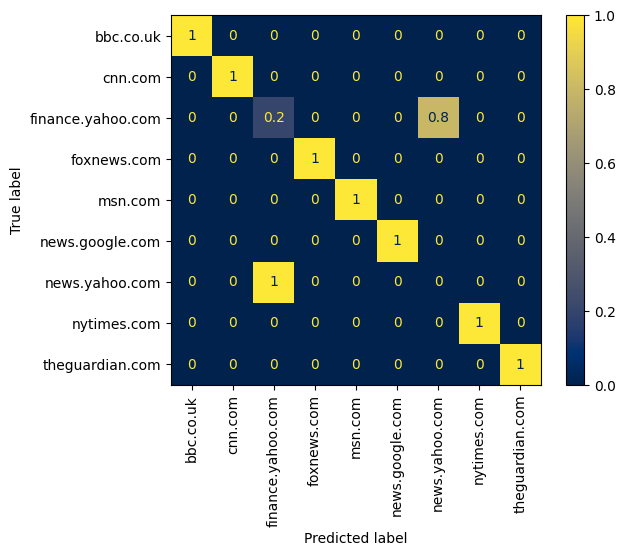

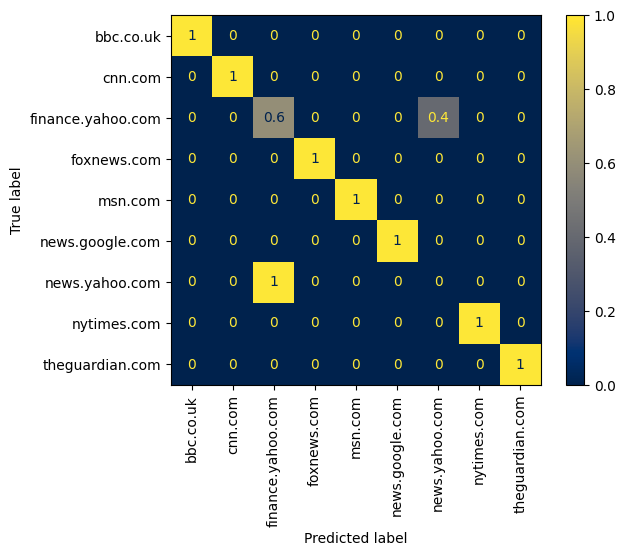

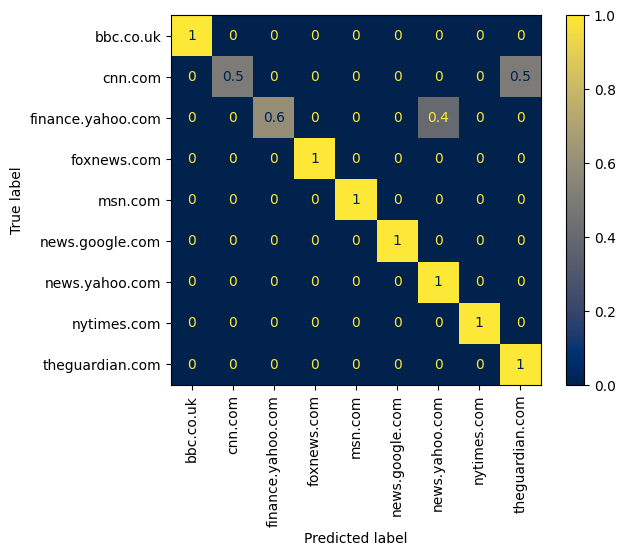

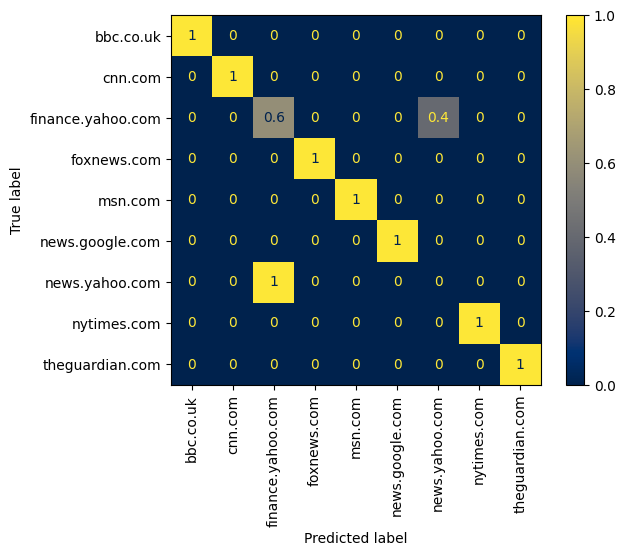

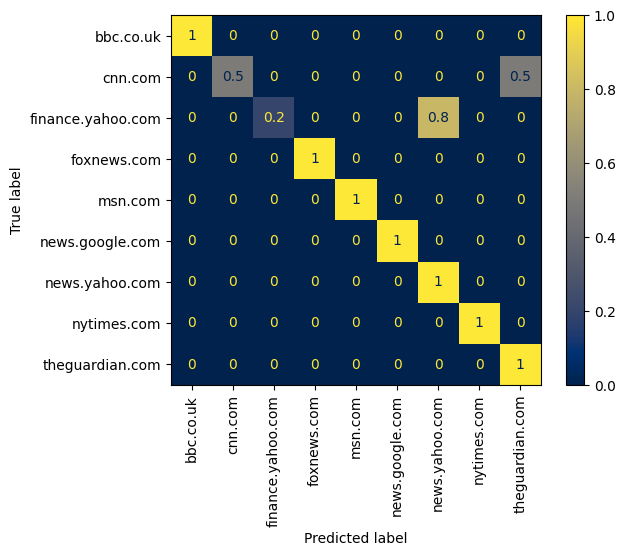

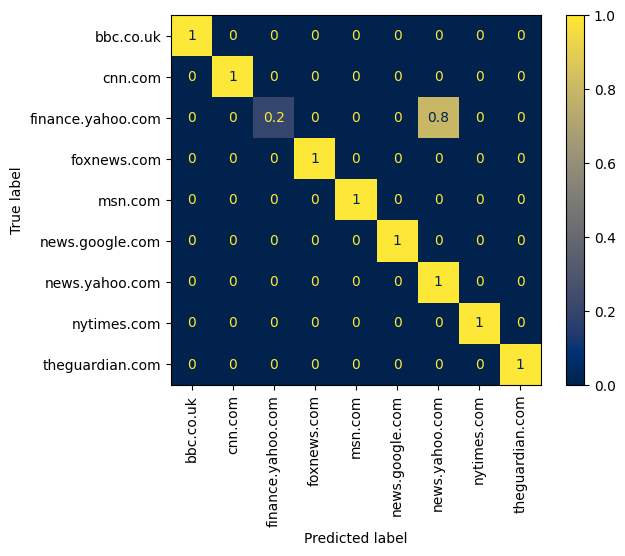

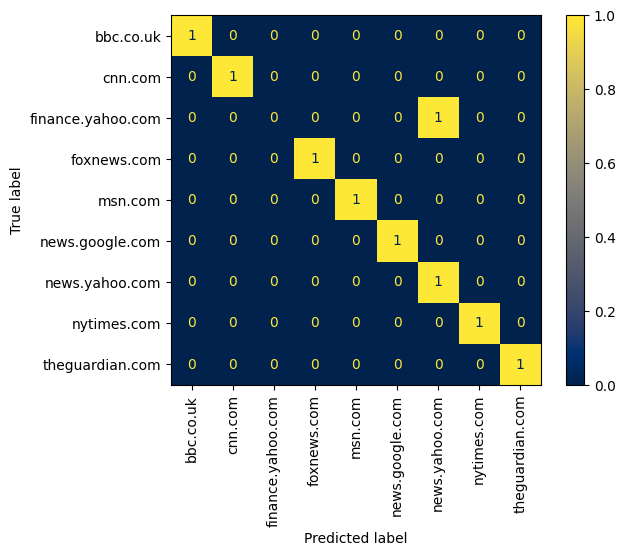

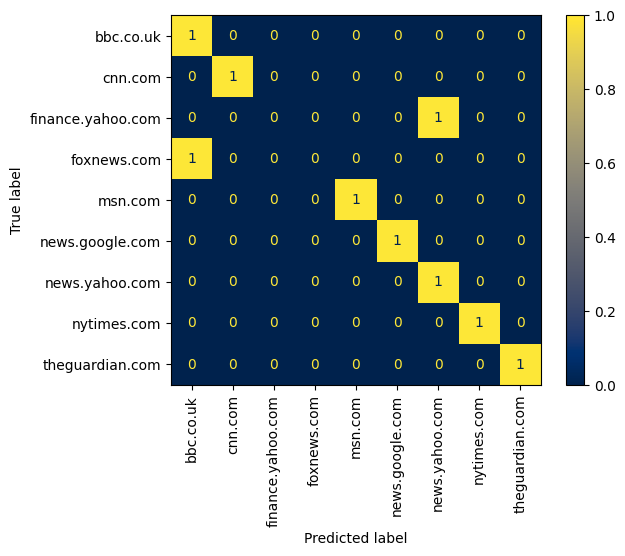

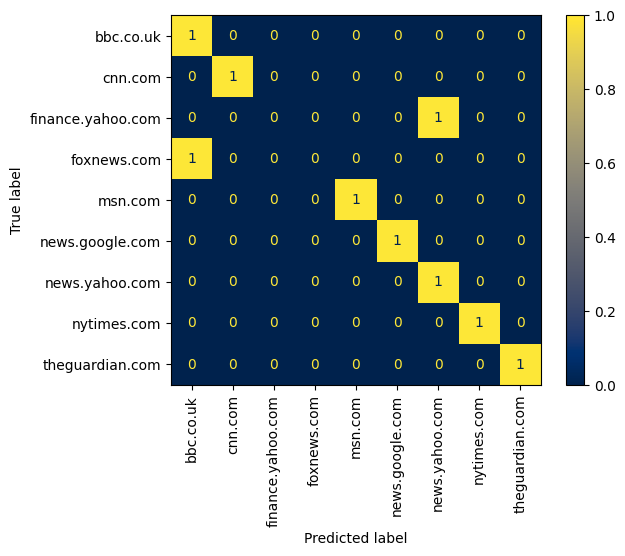

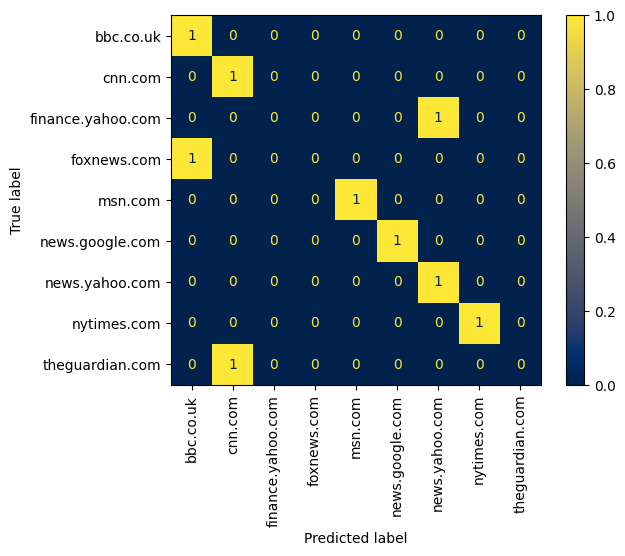

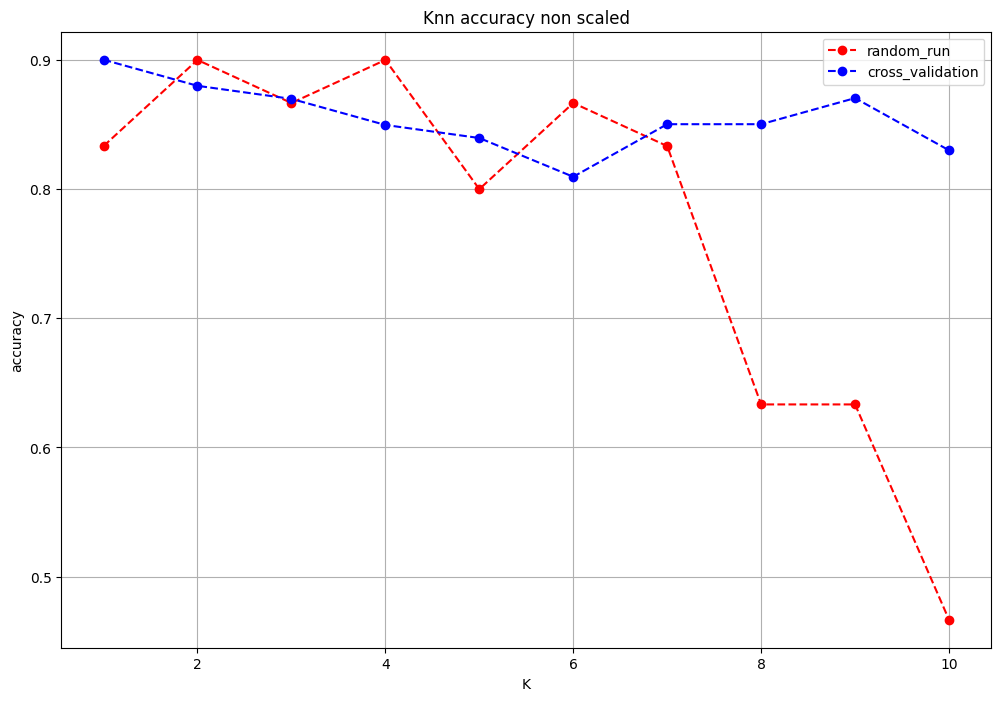

In [ ]:
import numpy as np
accuracy = []
scores = []

for k in range(1, 11):


  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, Y_train)
  Y_predict = knn.predict(X_test)
  accuracy.append(accuracy_score(Y_test,Y_predict))

  #Cross validation in order to get more robust results
  score = cross_val_score(knn, X, Y, cv=3)
  scores.append(np.mean(score))
  ConfusionMatrixDisplay.from_predictions(Y_test, Y_predict, xticks_rotation ='vertical', cmap='cividis', normalize = "true")

#PLOTTING THE RESULTS FOR NON SCALED DATASET
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,11)), accuracy,  linestyle='--', color='r', marker='o')
plt.plot(list(range(1,11)), scores,  linestyle='--', color='b', marker='o')
plt.legend(["random_run", "cross_validation"])
plt.title("Knn accuracy non scaled")
plt.grid()
plt.xlabel("K")
plt.ylabel("accuracy")


Text(0, 0.5, 'accuracy')

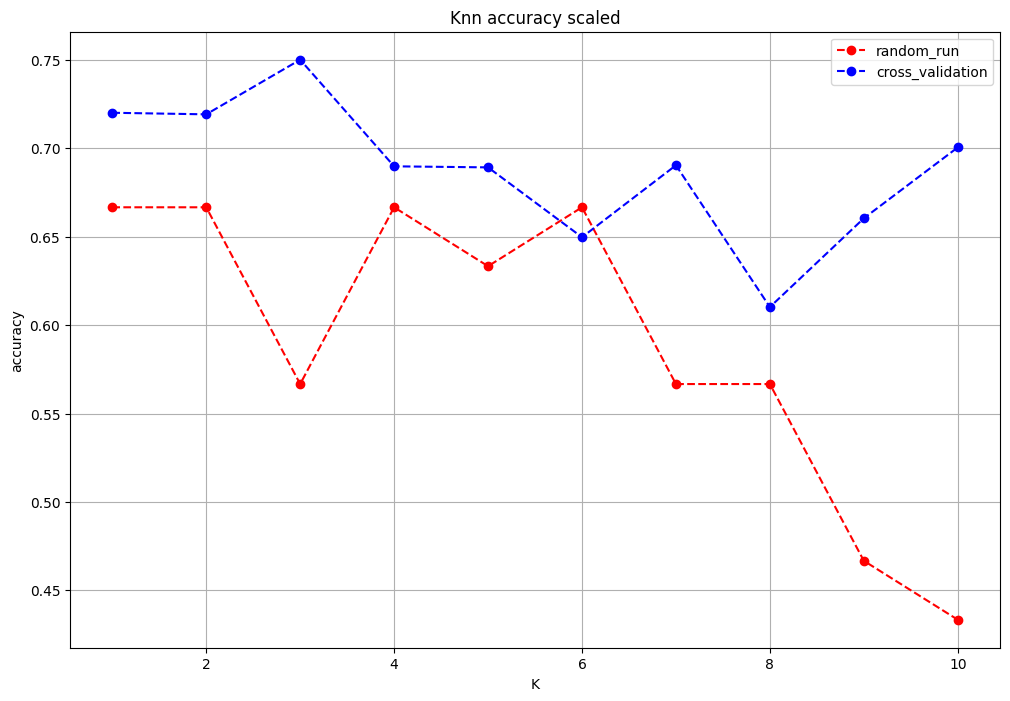

In [ ]:
scaled_scores = []
scaled_accuracy = []
X_scaled = scaler.fit_transform(X)
for k in range(1, 11):

  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, Y_train)
  Y_predict = knn.predict(X_test_scaled)
  scaled_accuracy.append(accuracy_score(Y_test,Y_predict))

  score = cross_val_score(knn, X_scaled, Y, cv=3)
  scaled_scores.append(np.mean(score))


#PLOTTING THE RESULTS FOR SCALED DATASET
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,11)), scaled_accuracy,  linestyle='--', color='r', marker='o')
plt.plot(list(range(1,11)), scaled_scores,  linestyle='--', color='b', marker='o')
plt.legend(["random_run", "cross_validation"])
plt.title("Knn accuracy scaled")
plt.grid()
plt.xlabel("K")
plt.ylabel("accuracy")


Text(0, 0.5, 'accuracy')

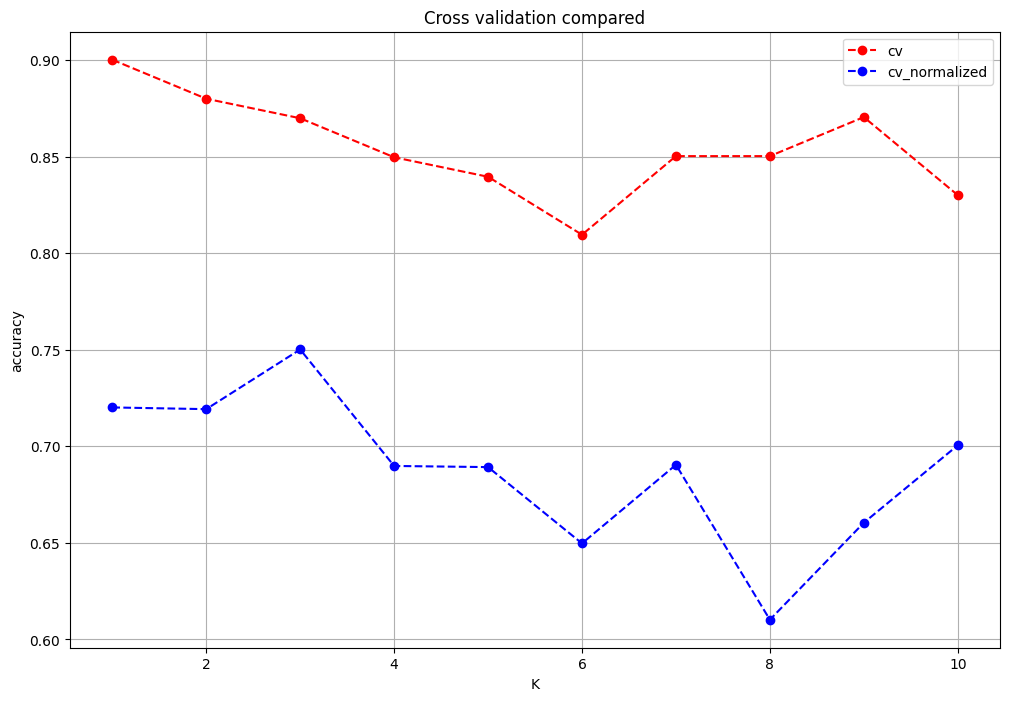

In [ ]:
#COMPARING NORMALIZED VS NON NORMALIZED VERSION OF KNN

plt.figure(figsize=(12, 8))
plt.plot(list(range(1,11)), scores,  linestyle='--', color='r', marker='o')
plt.plot(list(range(1,11)), scaled_scores,  linestyle='--', color='b', marker='o')
plt.legend(["cv", "cv_normalized"])
plt.title("Cross validation compared")
plt.grid()
plt.xlabel("K")
plt.ylabel("accuracy")

We can see that the overall model is affected very badly by the normalization. This may suggest that by normalizing the data we are giving more weight to one or multiple features which are not very relevant in the classification process.

We can see that the performance are decreasing when K is increasing. This make sense since the data used for training is 30% and this means that we are reducing the training set drammaticaly. In the most fair case we would have 7 instances for each website but this may not be the case. For this reason the cross-validation was added. The cross validation is a more robust way to analyze the accuracy of the system.
The cross validation is decreasing when K is increasing because up to a certain K it can happen that the correct class cannot have the majority. For example if the dataset have only 4 instances of a certain website then the majority for K=9 may be won by a website with very similar features with 5 instances in the dataset.

If we had a bigger dataset we could use even bigger values for K. Overall the algorithm have good performance.

# K-nearest neighbors after 24 hours


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

In [ ]:
Train = pd.read_csv("/content/dati_caricati/DATA_10_INSTANCE.csv", index_col=0)
Test = pd.read_csv("/content/dati_caricati/DATA_3_INSTANCE.csv", index_col=0)

In [ ]:
X_train = Train.drop(["label"], axis = 1)
Y_train = Train["label"]
X_test = Test.drop(["label"], axis = 1)
Y_test = Test["label"]

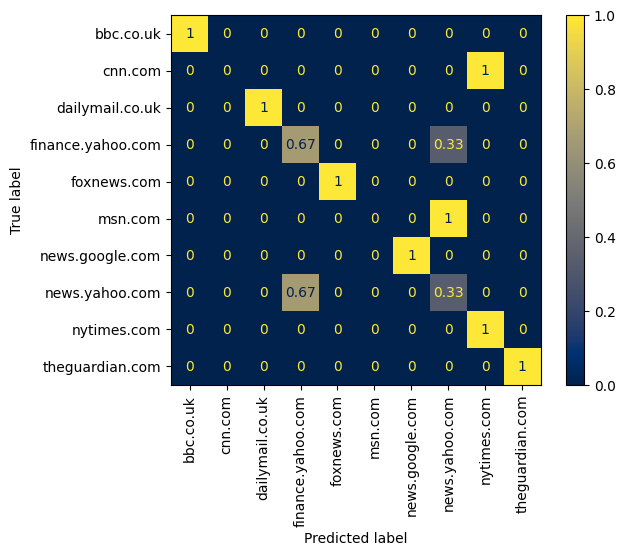

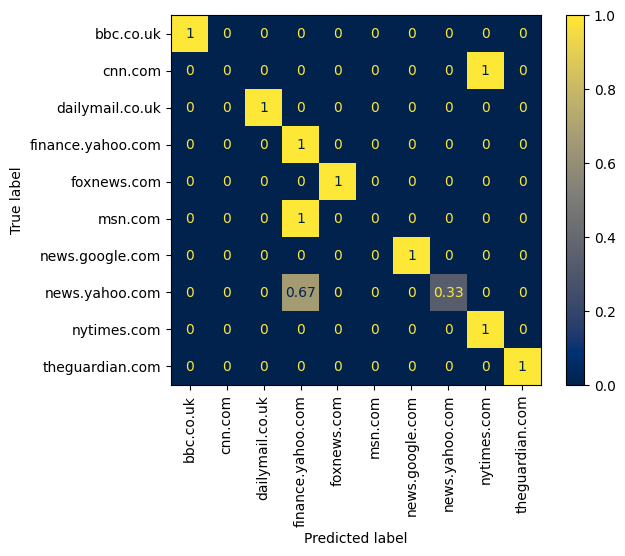

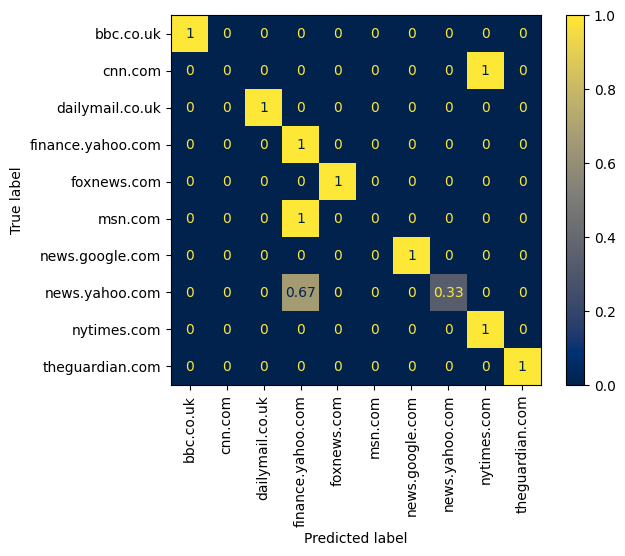

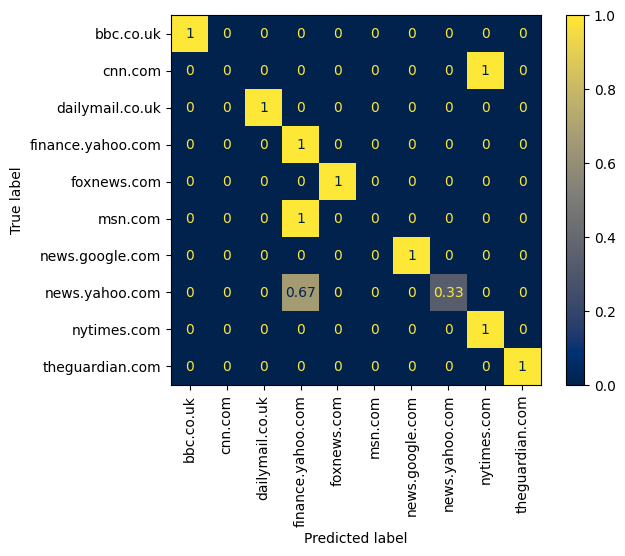

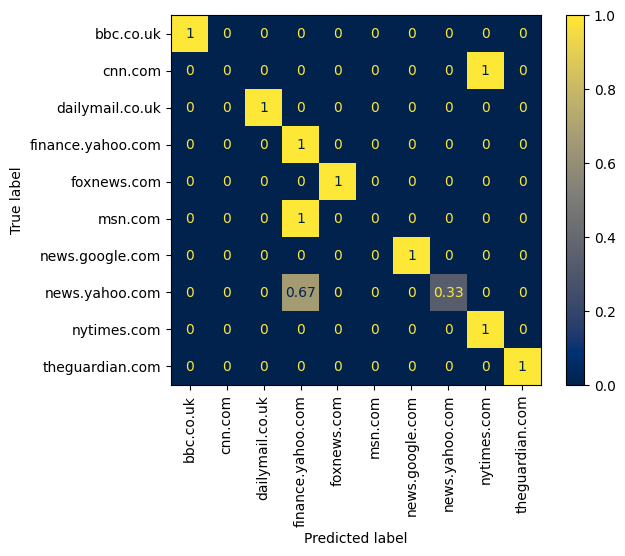

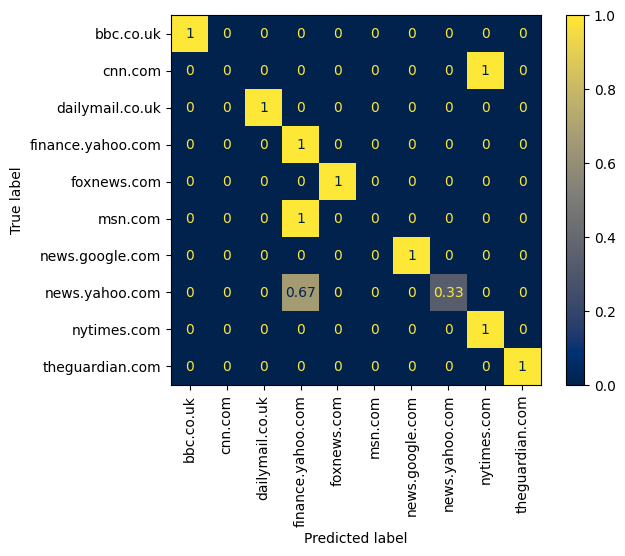

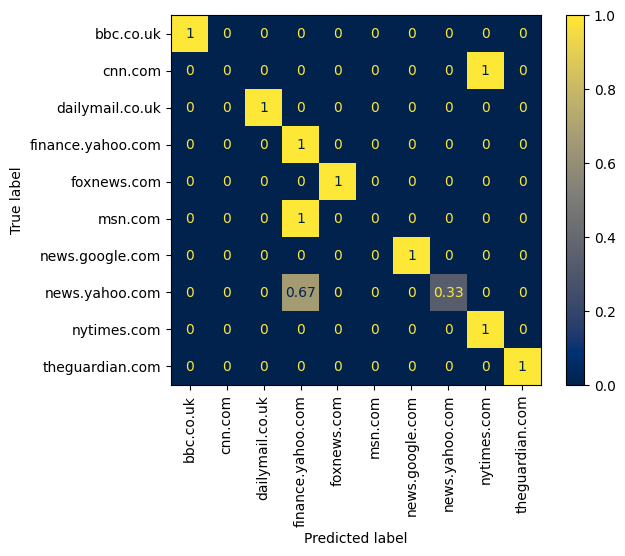

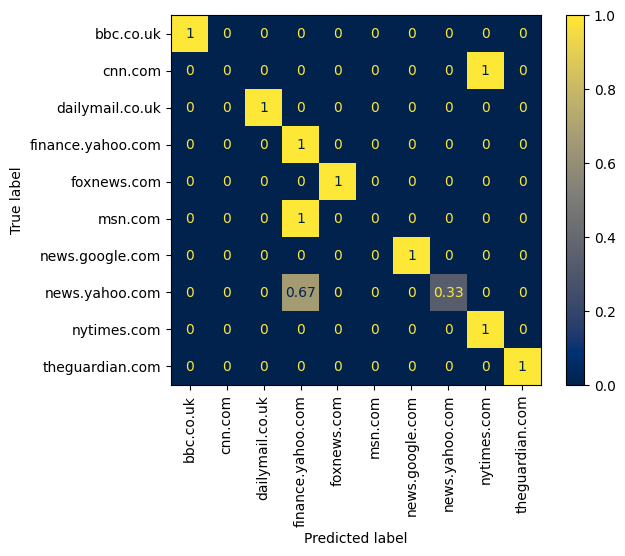

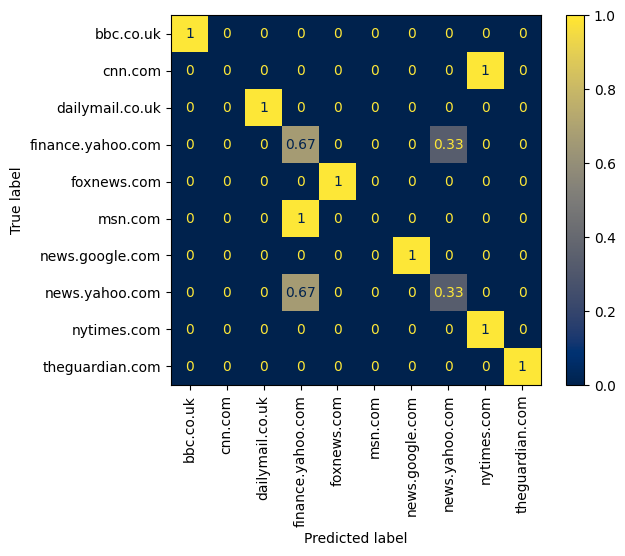

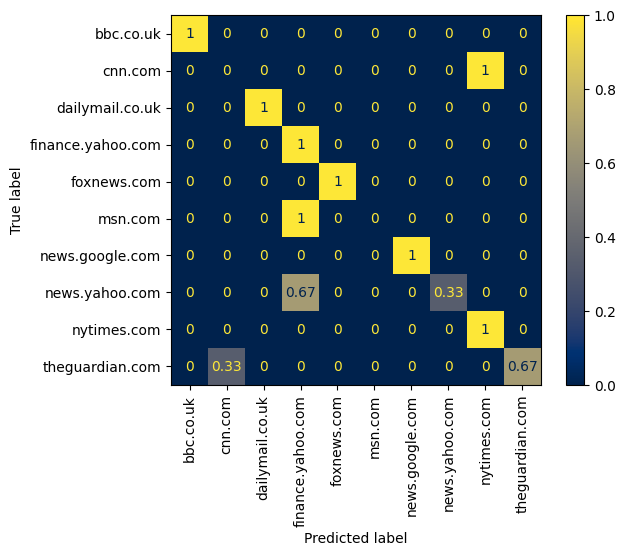

In [ ]:
accuracy = []
scores = []
for k in range(1, 11):


  knn = KNeighborsClassifier(n_neighbors=k, algorithm="brute")
  knn.fit(X_train, Y_train)

  Y_predict = knn.predict(X_test)
  accuracy.append(accuracy_score(Y_test,Y_predict))

  ConfusionMatrixDisplay.from_predictions(Y_test, Y_predict, xticks_rotation ='vertical', cmap='cividis', normalize = "true")

Text(0.5, 1.0, 'Accuracy after 1 day')

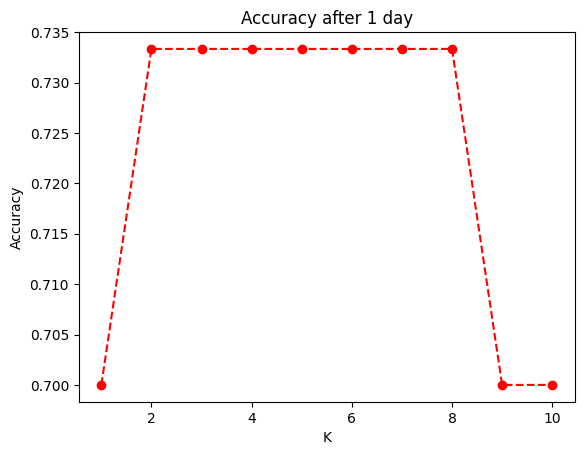

In [ ]:
plt.plot(list(range(1,11)), accuracy, "r--o")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy after 1 day")

<font size='4.8'> The result shows that the performance of the classification has dropped substantially after one day. This result can be explained considered that the data contained inside the websites changes and this means that the performance of a classifier will reduce in time. "**the accuracy of classification decreases by 40% in less than 10 days and further declines to zero after 90 days for Alexa Top 100 pages due to the content change**" [Website fingerprinting at internet scale Pachenko 2016]</font>

# CUMUL
Trying the CUMUL mechanism proposed by Pachenko. They showed a better perfomance in the classification process with respect to the "**Effective attacks and provable defenses for website fingerprinting**" [Wang 2014] while using less features.
Wang14 used a set of 3736 features while Pachenko16 used just 104 features.

Since in the previous implementation a set of **21 features** was tested with K-nn, a set of a similar number of features with the different approach will be tested in order to verify if an improvement is found. The features will be tested on k-NN instead of a Support Vector Machine as used in the article.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [ ]:
!unzip -q -o data_10_csv.zip -d csv_folder

In [ ]:
"""
FIRST OF ALL WE NEED TO ANALYZE ALL THE CSV FILE INSIDE THE DIRECTORY
AND WE NEED TO
"""
list_files = [i for i in os.listdir("/content/csv_folder") if '.csv' in i]


www.news.yahoo.com1.csv


'\nFor checking if the interpolation was working\n'

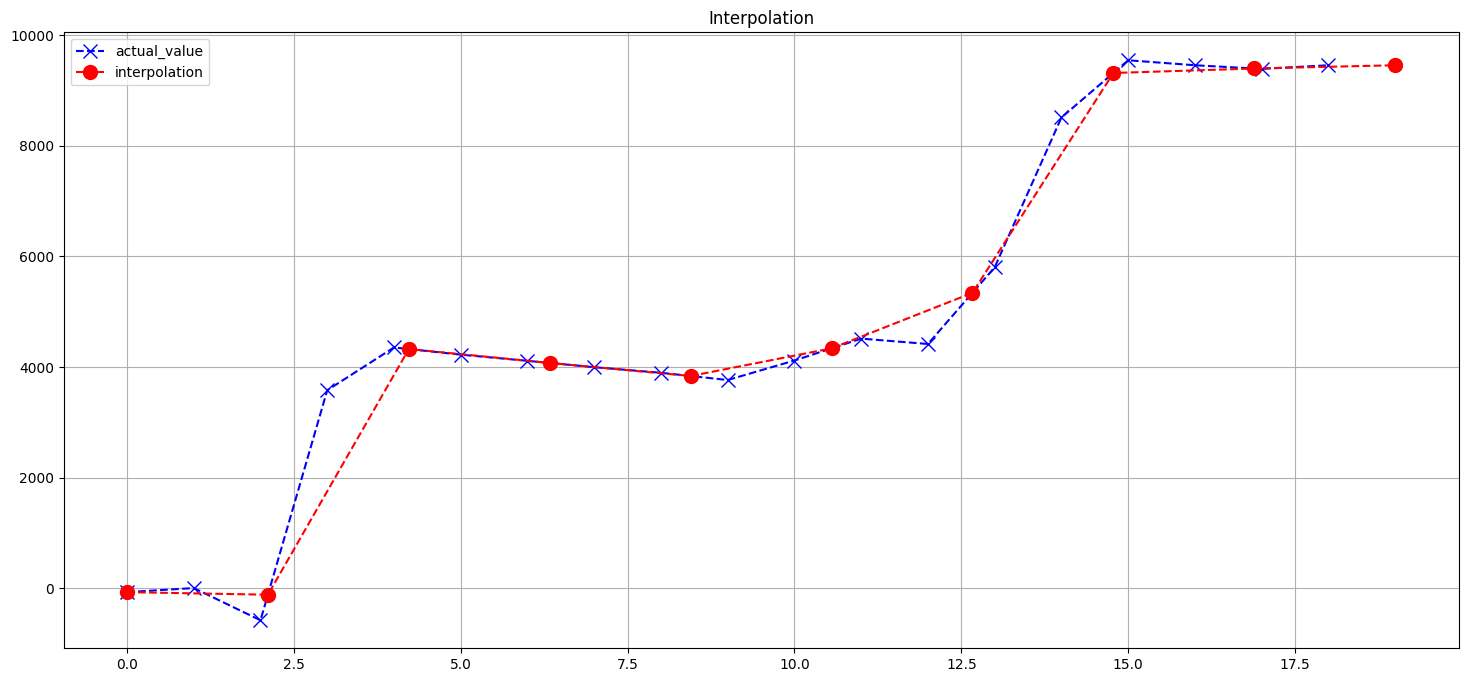

In [ ]:
number_features = 10


for filename in list_files:

  df = pd.read_csv("/content/csv_folder/" + filename, index_col=False)
  source = df.iloc[0,0]
  df_filtered = df[df["tcp.flags"] != "0x0010"].copy()
  df_filtered["direction"] = df_filtered["ip.src"].apply(lambda x: -1 if x==source else 1)
  df_filtered["trace"] = df_filtered["direction"] * df["frame.len"]
  riga = df_filtered["trace"].cumsum()
  n_packets = list(range(0,len(riga)))
  samples = np.linspace(0,len(riga), number_features)
  print(filename)
  samples_val = np.interp(samples,n_packets, riga )


  plt.figure(figsize=(18, 8))
  plt.title("Interpolation")
  plt.plot(n_packets, riga, color = "b", marker = "x", linestyle="--", markersize=10)
  plt.plot(samples, samples_val, color = "r", marker = "o", linestyle="--", markersize=10)
  plt.legend(["actual_value", "interpolation"])
  plt.grid()

  break

"""
For checking if the interpolation is working
"""

In [ ]:
number_features = 20

data = pd.DataFrame()

for filename in list_files:

  df = pd.read_csv("/content/csv_folder/" + filename, index_col=False)
  source = df.iloc[0,0]
  df_filtered = df[df["tcp.flags"] != "0x0010"].copy()
  df_filtered["direction"] = df_filtered["ip.src"].apply(lambda x: -1 if x==source else 1)
  df_filtered["trace"] = df_filtered["direction"] * df["frame.len"]
  riga = df_filtered["trace"].cumsum()
  n_packets = list(range(0,len(riga)))
  samples = np.linspace(0,len(riga), number_features)

  #Now we have to add the vector and i use a dictionary
  samples_val = np.interp(samples,n_packets, riga )
  dictionary = {str(i):[samples_val[i]] for i in range(len(samples_val))}
  dictionary["label"] = [re.search(r"\.\D*",filename).group()[1:]]
  row = pd.DataFrame(dictionary)

  data = pd.concat([data,row])

data = data.reset_index(drop=True)
#At the end we save the csv
data.to_csv("Data_interp.csv")


# KNN on CUMUL

In [ ]:
data = pd.read_csv("Data_interp.csv", index_col=False)
X = data.drop(["label"], axis = 1)
Y = data["label"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)

accuracy_CUMUL = []
scores_CUMUL = []
for k in range(1, 11):

  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, Y_train)
  Y_predict = knn.predict(X_test)
  Y_predict_day = knn.predict(X_test)
  accuracy_CUMUL.append(accuracy_score(Y_test,Y_predict))

  score = cross_val_score(knn, X, Y, cv=3)
  scores_CUMUL.append(np.mean(score))

Text(0, 0.5, 'accuracy')

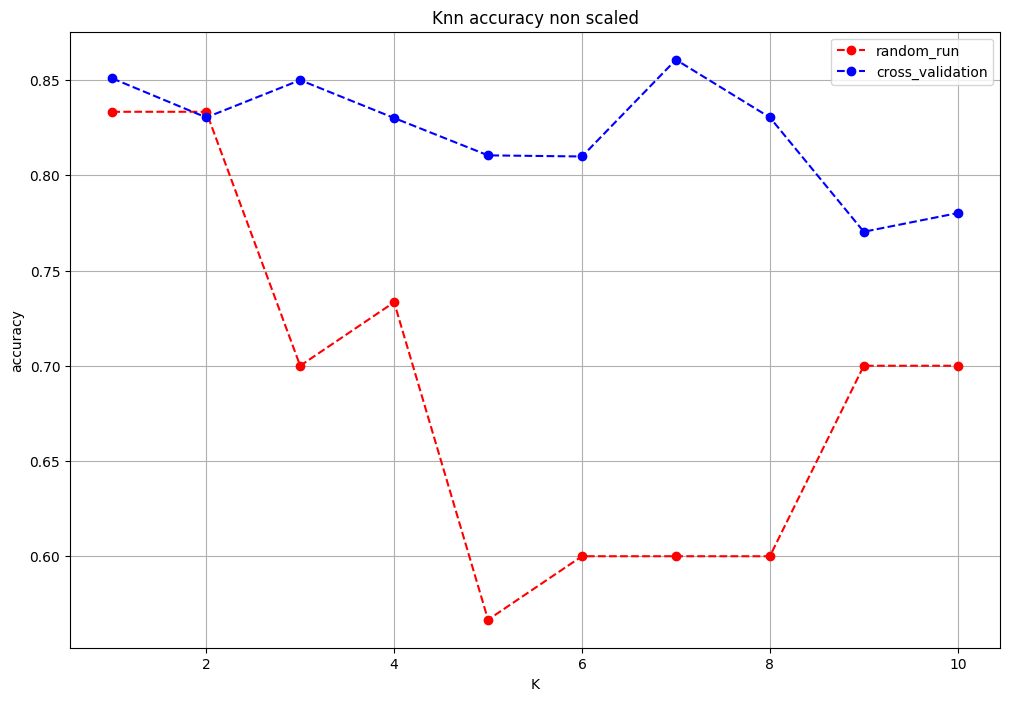

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,11)), accuracy_CUMUL,  linestyle='--', color='r', marker='o')
plt.plot(list(range(1,11)), scores_CUMUL,  linestyle='--', color='b', marker='o')
plt.legend(["random_run", "cross_validation"])
plt.title("Knn accuracy non scaled")
plt.grid()
plt.xlabel("K")
plt.ylabel("accuracy")

#Final comment

The CUMUL technique as good results in terms of accuracy, they are very close to the first method.
This does not prove that the first technique is better, indeed in the article they proved that the CUMUL showed better results.

A very good advantage of this technique is that you can choose the number of features very easily by deciding how many points you want in the interpolation.

Also in this case there is a slow decrease of the performance when K increase but this is due to the same reason of the first one. Indeed the best values for K in both techniques are small in order to let the right class win the majority.